In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from tqdm import tqdm
import gc
import time
import random



import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.cuda.is_available()

True

In [29]:
def asses_model(model_name, y_pred, y_test, labels_order):
    print()
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_pred, y_test)

    # Print accuracy and Cohen Kappa score with explanations
    print(f'Accuracy of {model_name}: {accuracy:.4f}')
    print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

    # Calculate the normalized predicted label count
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred)}
    
    # Calculate the percent the model over or under predicted the labels using the specified label order
    sorted_values = [normalized_counts_pred[k] - 1 if k in normalized_counts_pred else 0 for k in labels_order]

    # Plotting the percent the model over or under predicted the labels
    plt.figure(figsize=(2*len(labels_order), 4))
    plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
    plt.title(f'Percent Model {model_name} Over or Under Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Percent Over/Under Prediction')
    
    # Center y-axis and set equal extension above and below
    max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
    plt.ylim(-max_extent, max_extent)
    plt.axhline(y=0, color='gray', linewidth=0.8)
    plt.show()

    # Display each confusion matrix on its own row
    for norm in [None, 'true', 'pred']:
        plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
        ax = plt.gca()
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize=norm, ax=ax,
            xticks_rotation='vertical', labels=labels_order
        )
        ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
        plt.tight_layout()
        plt.show()
        

# def asses_model(model_name, y_pred, y_test, labels_order):
#     # Calculate metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     kappa = cohen_kappa_score(y_pred, y_test)

#     # Print accuracy and Cohen Kappa score
#     print(f'Accuracy of {model_name}: {accuracy:.4f}')
#     print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

#     # Calculate the normalized predicted label count
#     unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
#     unique_test, counts_test = np.unique(y_test, return_counts=True)
#     normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred) if k in unique_test}
    
#     # Calculate the percent the model over or under predicted the labels
#     sorted_values = [normalized_counts_pred.get(k, 0) - 1 for k in labels_order]

#     # Plotting the percent the model over or under predicted the labels
#     plt.figure(figsize=(2*len(labels_order), 4))
#     plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
#     plt.title(f'Percent {model_name} Over or Under Predicted Labels')
#     plt.xlabel('Labels')
#     plt.ylabel('Percent Over/Under Prediction')

#     # Center y-axis and set equal extension above and below
#     max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
#     plt.ylim(-max_extent, max_extent)
#     plt.axhline(y=0, color='gray', linewidth=0.8)
#     plt.show()

#     # Display each confusion matrix on its own row
#     for norm in [None, 'true', 'pred']:
#         plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
#         ax = plt.gca()
#         ConfusionMatrixDisplay.from_predictions(
#             y_test, y_pred, normalize=norm, ax=ax,
#             display_labels=labels_order,
#             xticks_rotation='vertical'
#         )
#         ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
#         ax.set_xlabel('Predicted labels')
#         ax.set_ylabel('True labels')
#         ax.set_xticklabels(labels_order)  # Explicitly setting x-axis labels
#         ax.set_yticklabels(labels_order[::-1])  # Setting y-axis labels to reverse order
#         plt.tight_layout()
#         plt.show()

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay

# def asses_model(model_name, y_pred, y_test, labels_order, label_decoder):
#     """
#     Evaluate and visualize the model's performance with decoded labels.

#     Args:
#         model_name (str): Name of the model for display purposes.
#         y_pred (np.ndarray): Encoded predictions from the model.
#         y_test (np.ndarray): Encoded true labels.
#         labels_order (list): Ordered list of labels for display.
#         label_decoder (dict): Dictionary to decode labels from encoded labels to string labels.
#     """
#     # Decode predictions and true labels
#     decoded_y_pred = [label_decoder.get(label, "Unknown") for label in y_pred]
#     decoded_y_test = [label_decoder.get(label, "Unknown") for label in y_test]

#     # Calculate metrics
#     accuracy = accuracy_score(decoded_y_test, decoded_y_pred)
#     kappa = cohen_kappa_score(decoded_y_pred, decoded_y_test)
#     print(f'Accuracy of {model_name}: {accuracy:.4f}')
#     print(f'Cohen Kappa Score of {model_name}: {kappa:.4f}')

#     # Normalize the predicted label counts
#     unique_pred, counts_pred = np.unique(decoded_y_pred, return_counts=True)
#     unique_test, counts_test = np.unique(decoded_y_test, return_counts=True)
#     normalized_counts_pred = {k: v / counts_test[np.where(unique_test == k)[0][0]] for k, v in zip(unique_pred, counts_pred) if k in unique_test}
    
#     # Calculate and plot the percent the model over or under predicted the labels
#     sorted_values = [normalized_counts_pred.get(k, 0) - 1 for k in labels_order]
#     plt.figure(figsize=(2*len(labels_order), 4))
#     plt.bar(labels_order, sorted_values, color=['green' if x > 0 else 'blue' for x in sorted_values])
#     plt.title(f'Percent {model_name} Over or Under Predicted Labels')
#     plt.xlabel('Labels')
#     plt.ylabel('Percent Over/Under Prediction')
#     max_extent = max(abs(min(sorted_values)), abs(max(sorted_values))) * 1.05
#     plt.ylim(-max_extent, max_extent)
#     plt.axhline(y=0, color='gray', linewidth=0.8)
#     plt.show()

#     # Display each confusion matrix
#     for norm in [None, 'true', 'pred']:
#         plt.figure(figsize=(len(labels_order)+5, len(labels_order)+5))
#         ax = plt.gca()
#         ConfusionMatrixDisplay.from_predictions(
#             decoded_y_test, decoded_y_pred, normalize=norm, ax=ax,
#             display_labels=labels_order,
#             xticks_rotation='vertical'
#         )
#         ax.title.set_text(f'{model_name} Confusion Matrix ({"Not Normalized" if norm is None else "Normalized by " + norm})')
#         ax.set_xlabel('Predicted labels')
#         ax.set_ylabel('True labels')
#         ax.set_xticklabels(labels_order)
#         ax.set_yticklabels(labels_order[::-1])
#         plt.tight_layout()
#         plt.show()


In [30]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True]
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [31]:
# # We classify 5 characters on competitive stages

# source_data = ['ranked']

# general_features = {
#     'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
#     'num_players': [2],
#     'conclusive': [True]
# }
# player_features = {
#     # 'netplay_code': ['MANG#0'],
#     'character_name': ['FOX'],
#     'type_name': ['HUMAN']
    
# }
# opposing_player_features = {
#     'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
#     # 'netplay_code': ['KOD#0', 'ZAIN#0'],
#     'type_name': ['HUMAN']
# }
# label_info = {
#     'source': ['opposing_player'], # Can be 'general', 'player', 'opposing_player'
#     # 'feature': ['netplay_code']
#     'feature': ['character_name']
# }
    

In [32]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())

/workspace/slp_jaspar/autoencoder/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
BOWSER               940
Name: labels, dtype: int64


In [33]:
labels_order =  dataset.number_of_segments_per_game(12,300000)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count  Shift
0              FOX  102117   1841
1            FALCO   89884   1584
2            MARTH   53341   1054
3   CAPTAIN_FALCON   37618    658
4            SHEIK   27478    615
5            PEACH   17331    422
6       JIGGLYPUFF   16107    374
7            SAMUS    9466    256
8     ICE_CLIMBERS    6807    168
9        GANONDORF    6587    124
10           YOSHI    5697    127
11           LUIGI    5190    121
12        DR_MARIO    4169     95
13         PIKACHU    4057     95
14            LINK    2487     60
15            NESS    2288     66
16     DONKEY_KONG    2001     45
17  GAME_AND_WATCH    1944     35
18          MEWTWO    1756     51
19          BOWSER     933     24


In [34]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

In [35]:
train_df.head()

,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,ranked\FALCO\e8013fa4-511a-4e83-9d3e-bbdfeead8...,FALCO,4,0,0,4096
1,ranked\FALCO\e8013fa4-511a-4e83-9d3e-bbdfeead8...,FALCO,4,1583,1,4096
2,ranked\FALCO\e8013fa4-511a-4e83-9d3e-bbdfeead8...,FALCO,4,3166,2,4096
3,ranked\FALCO\e8013fa4-511a-4e83-9d3e-bbdfeead8...,FALCO,4,4749,3,4096
4,ranked\FALCO\e8013fa4-511a-4e83-9d3e-bbdfeead8...,FALCO,4,6332,4,4096


In [36]:
labels_unique = train_df['labels'].unique()
encoded_labels_unique = train_df['encoded_labels'].unique()
label_decoder = zip(labels_unique, encoded_labels_unique)
label_decoder = dict(zip(encoded_labels_unique, labels_unique)) 
print(label_decoder)

{4: 'FALCO', 12: 'MARTH', 5: 'FOX', 1: 'CAPTAIN_FALCON', 18: 'SHEIK', 9: 'JIGGLYPUFF', 3: 'DR_MARIO', 19: 'YOSHI', 16: 'PIKACHU', 17: 'SAMUS', 8: 'ICE_CLIMBERS', 11: 'LUIGI', 15: 'PEACH', 0: 'BOWSER', 2: 'DONKEY_KONG', 7: 'GANONDORF', 10: 'LINK', 14: 'NESS', 6: 'GAME_AND_WATCH', 13: 'MEWTWO'}


In [37]:
from ResNet_Model import ResNet50, ResNet101

model = ResNet50(num_classes=20, channels=9).to('cuda')


In [38]:
# # Create a dummy input with the correct shape
# dummy_input = torch.randn(1, 9, 4096)  # batch size of 1, 9 channels, 4096 length
# try:
#     with torch.no_grad():
#         model(dummy_input.to(model.device))  # Ensure the dummy input is on the same device as the model
# except Exception as e:
#     print("Error during test forward pass: ", str(e))



In [39]:
summary(model, input_size=(9, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2048]           4,032
       BatchNorm1d-2             [-1, 64, 2048]             128
              ReLU-3             [-1, 64, 2048]               0
         MaxPool1d-4             [-1, 64, 1024]               0
            Conv1d-5             [-1, 64, 1024]           4,160
       BatchNorm1d-6             [-1, 64, 1024]             128
              ReLU-7             [-1, 64, 1024]               0
            Conv1d-8             [-1, 64, 1024]          12,352
       BatchNorm1d-9             [-1, 64, 1024]             128
             ReLU-10             [-1, 64, 1024]               0
           Conv1d-11            [-1, 256, 1024]          16,640
      BatchNorm1d-12            [-1, 256, 1024]             512
           Conv1d-13            [-1, 256, 1024]          16,640
      BatchNorm1d-14            [-1, 25

In [40]:
# model = torch.compile(model, mode = 'default').to('cuda')
model = torch.compile(model, mode='max-autotune')
# model = model.to('cuda')

In [41]:
loaders = slp_pytorch_functions.prepare_data_loaders_no_val(train_df, test_df, 32*2, 16)
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = Adam(model.parameters(), lr=0.001)
# optimizer = SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
slp_pytorch_functions.train_model(model, criterion,optimizer, loaders, 'cuda', 3 )
y_pred = slp_pytorch_functions.predict(model, loaders['test'], 'cuda' )


Epoch 1/3:   0%|          | 0/75000 [00:00<?, ?batch/s]AUTOTUNE mm(64x20, 20x2048)
  triton_mm_60 0.0041 ms 100.0%
  triton_mm_61 0.0041 ms 100.0%
  triton_mm_62 0.0041 ms 100.0%
  triton_mm_64 0.0041 ms 100.0%
  triton_mm_65 0.0041 ms 100.0%
  triton_mm_58 0.0041 ms 99.2%
  triton_mm_56 0.0042 ms 98.5%
  triton_mm_63 0.0043 ms 94.8%
  mm 0.0049 ms 83.1%
  triton_mm_66 0.0050 ms 82.6%
SingleProcess AUTOTUNE takes 2.6409 seconds
AUTOTUNE mm(20x64, 64x2048)
  triton_mm_71 0.0041 ms 100.0%
  triton_mm_72 0.0041 ms 100.0%
  triton_mm_74 0.0041 ms 100.0%
  triton_mm_70 0.0042 ms 98.5%
  triton_mm_77 0.0044 ms 92.8%
  triton_mm_76 0.0049 ms 83.7%
  triton_mm_73 0.0050 ms 82.1%
  mm 0.0051 ms 80.0%
  triton_mm_68 0.0051 ms 80.0%
  triton_mm_69 0.0051 ms 80.0%
SingleProcess AUTOTUNE takes 2.6852 seconds
Epoch 2/3:  15%|█▍        | 11180/75000 [05:29<31:37, 33.64batch/s, accuracy=99.8, loss=0.00707][W CUDAGraph.cpp:338] Warning: CUDA warning: initialization error (function reset)
[W CUDAGraph.c


Accuracy of ResNet-50: 0.9956
Cohen Kappa Score of ResNet-50: 0.9954


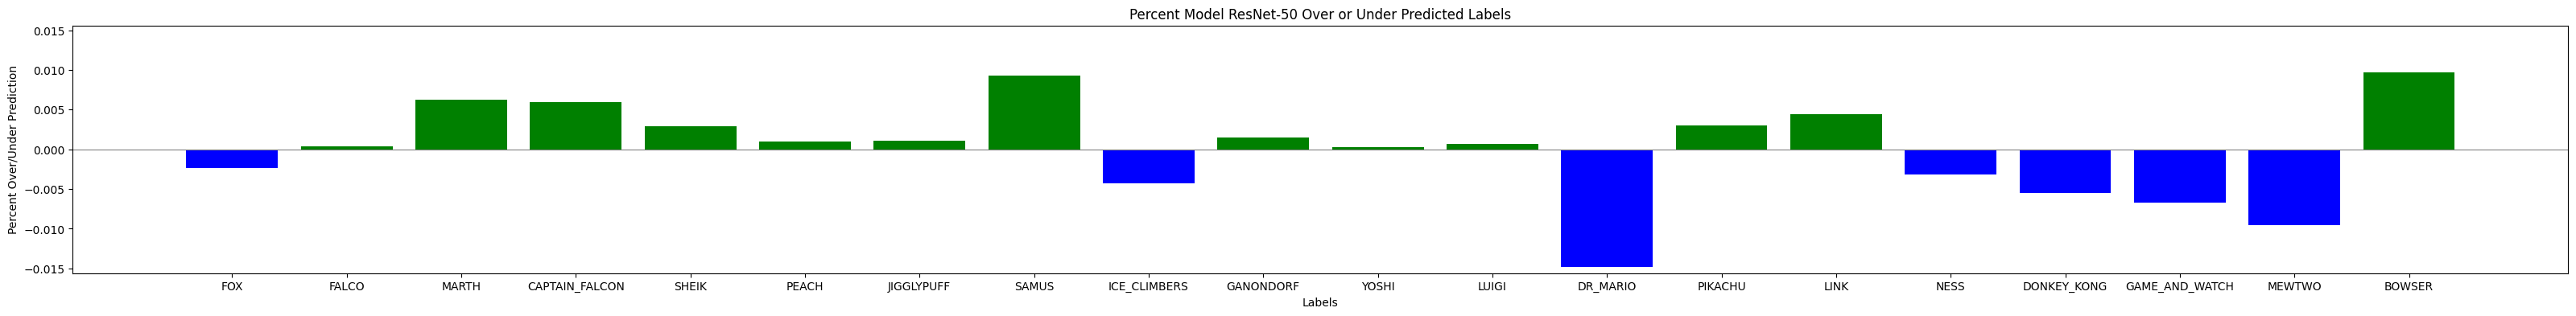

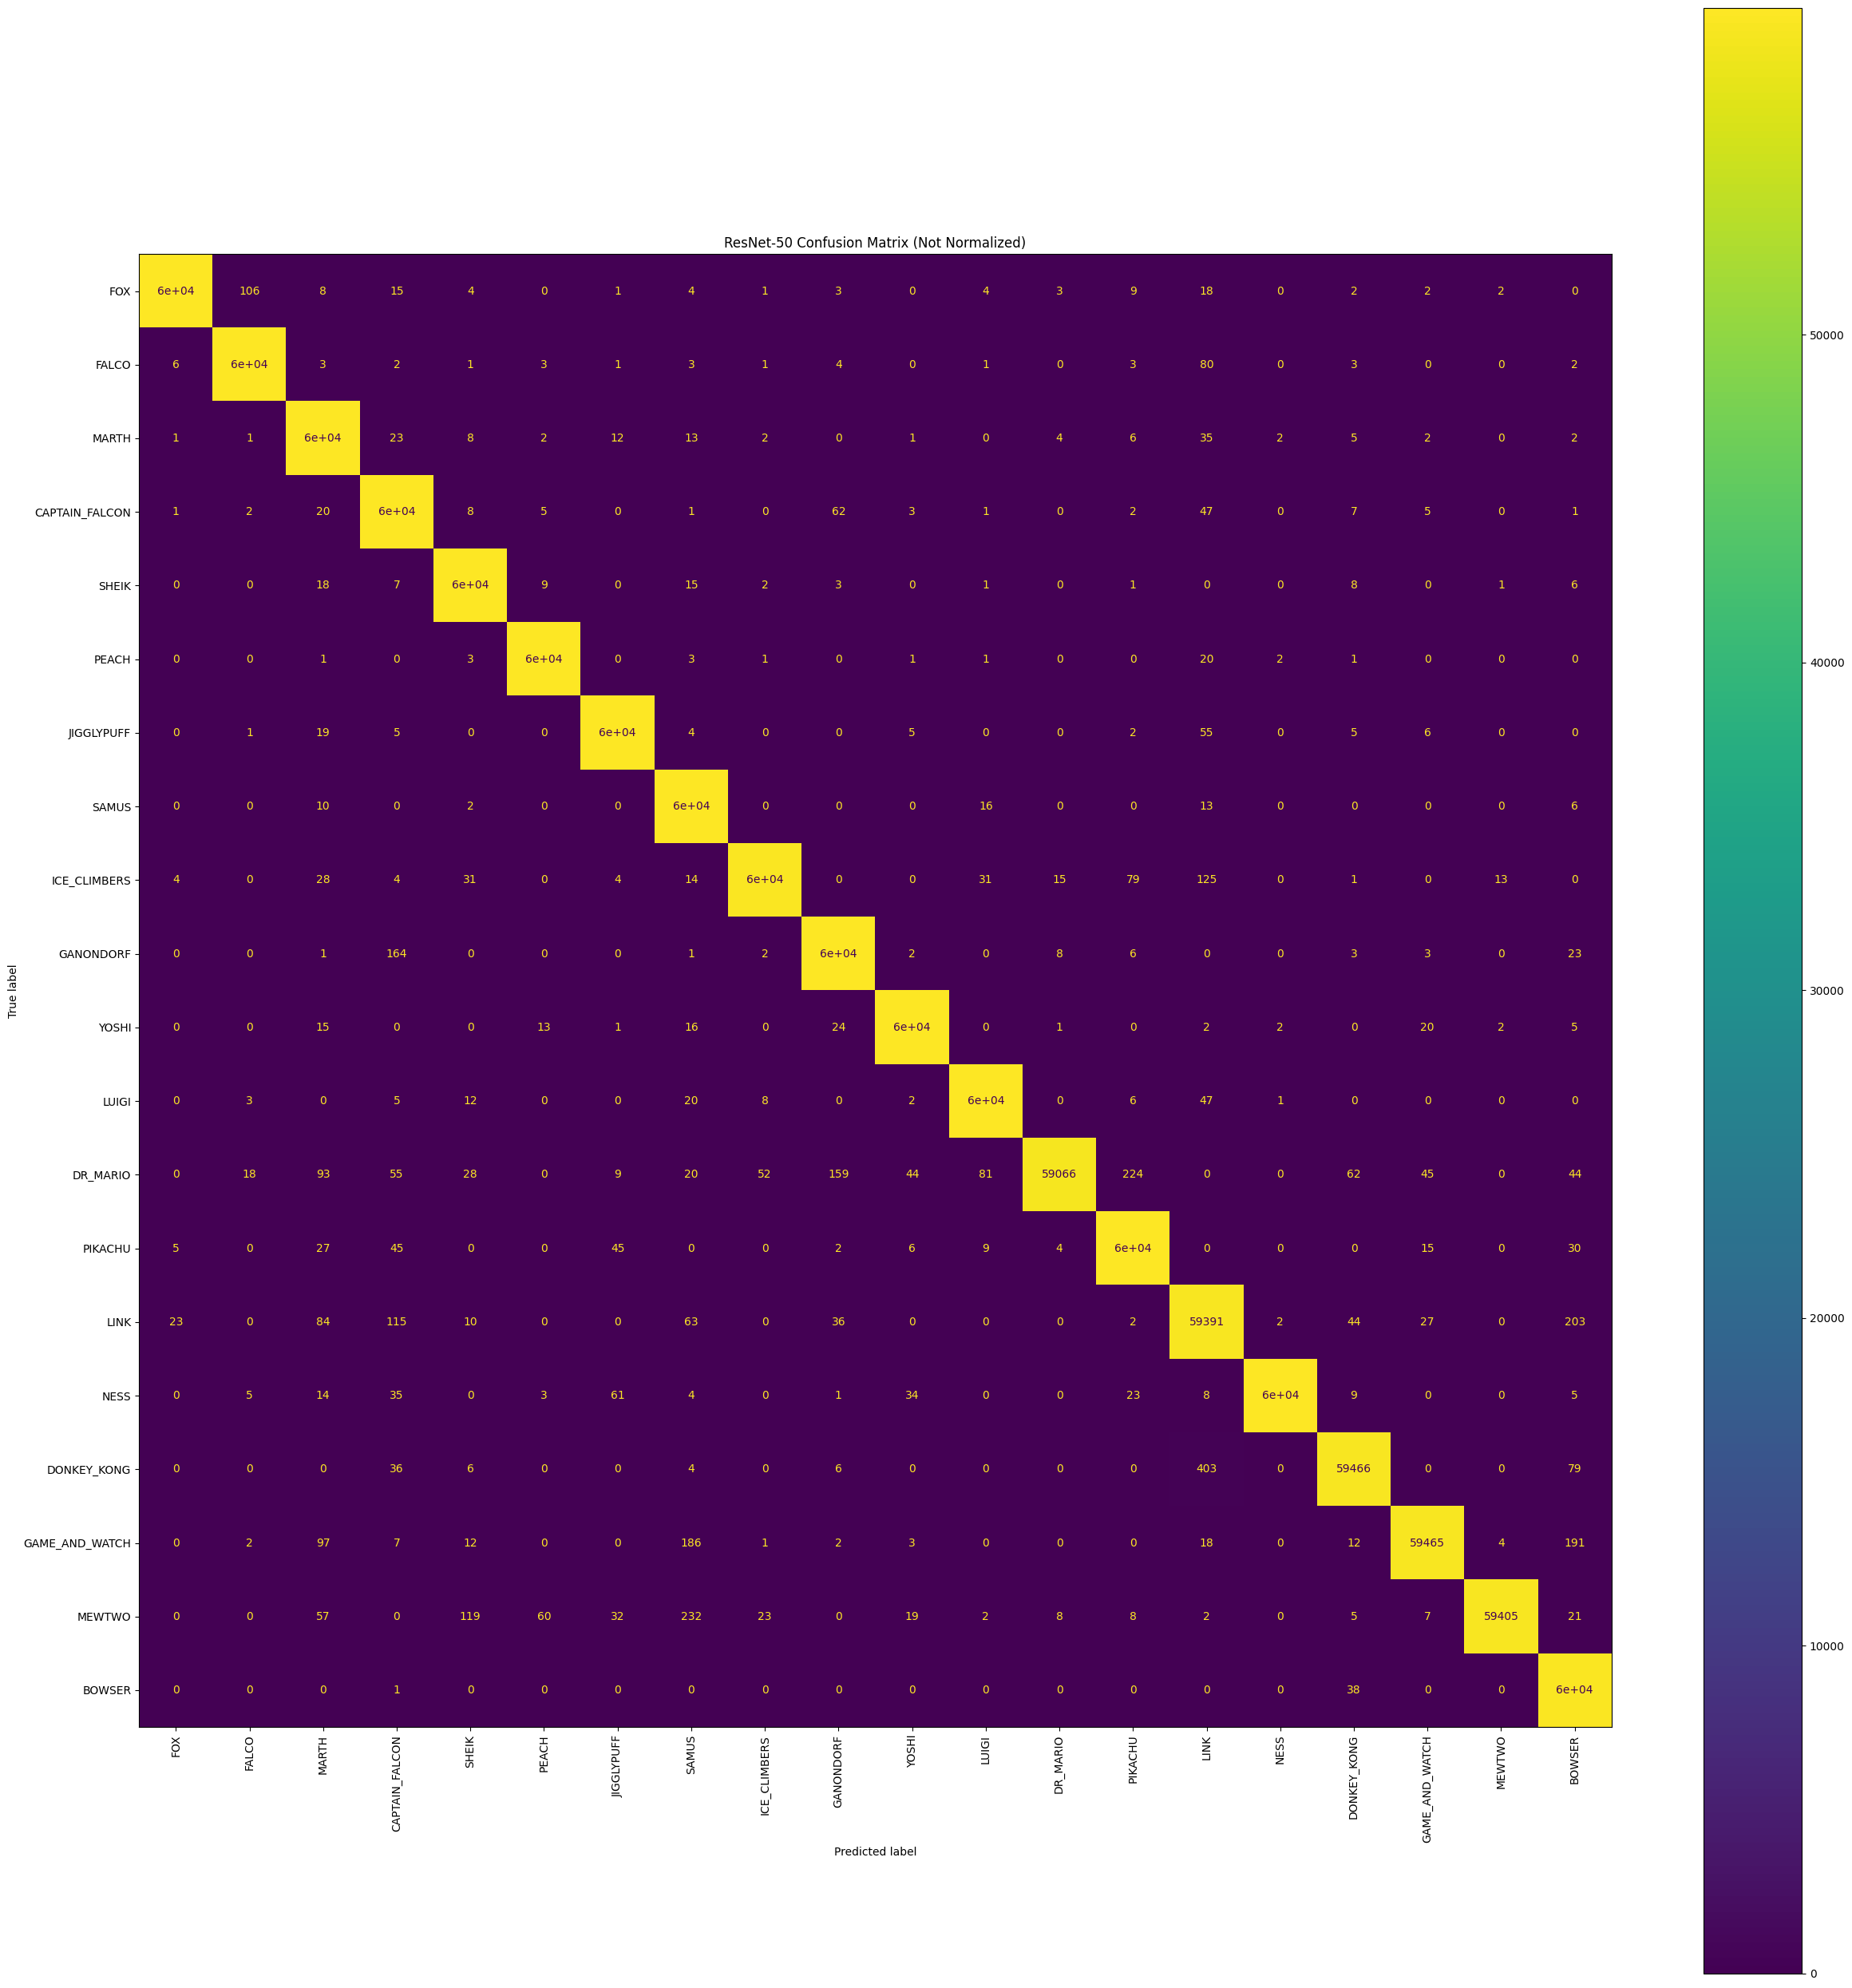

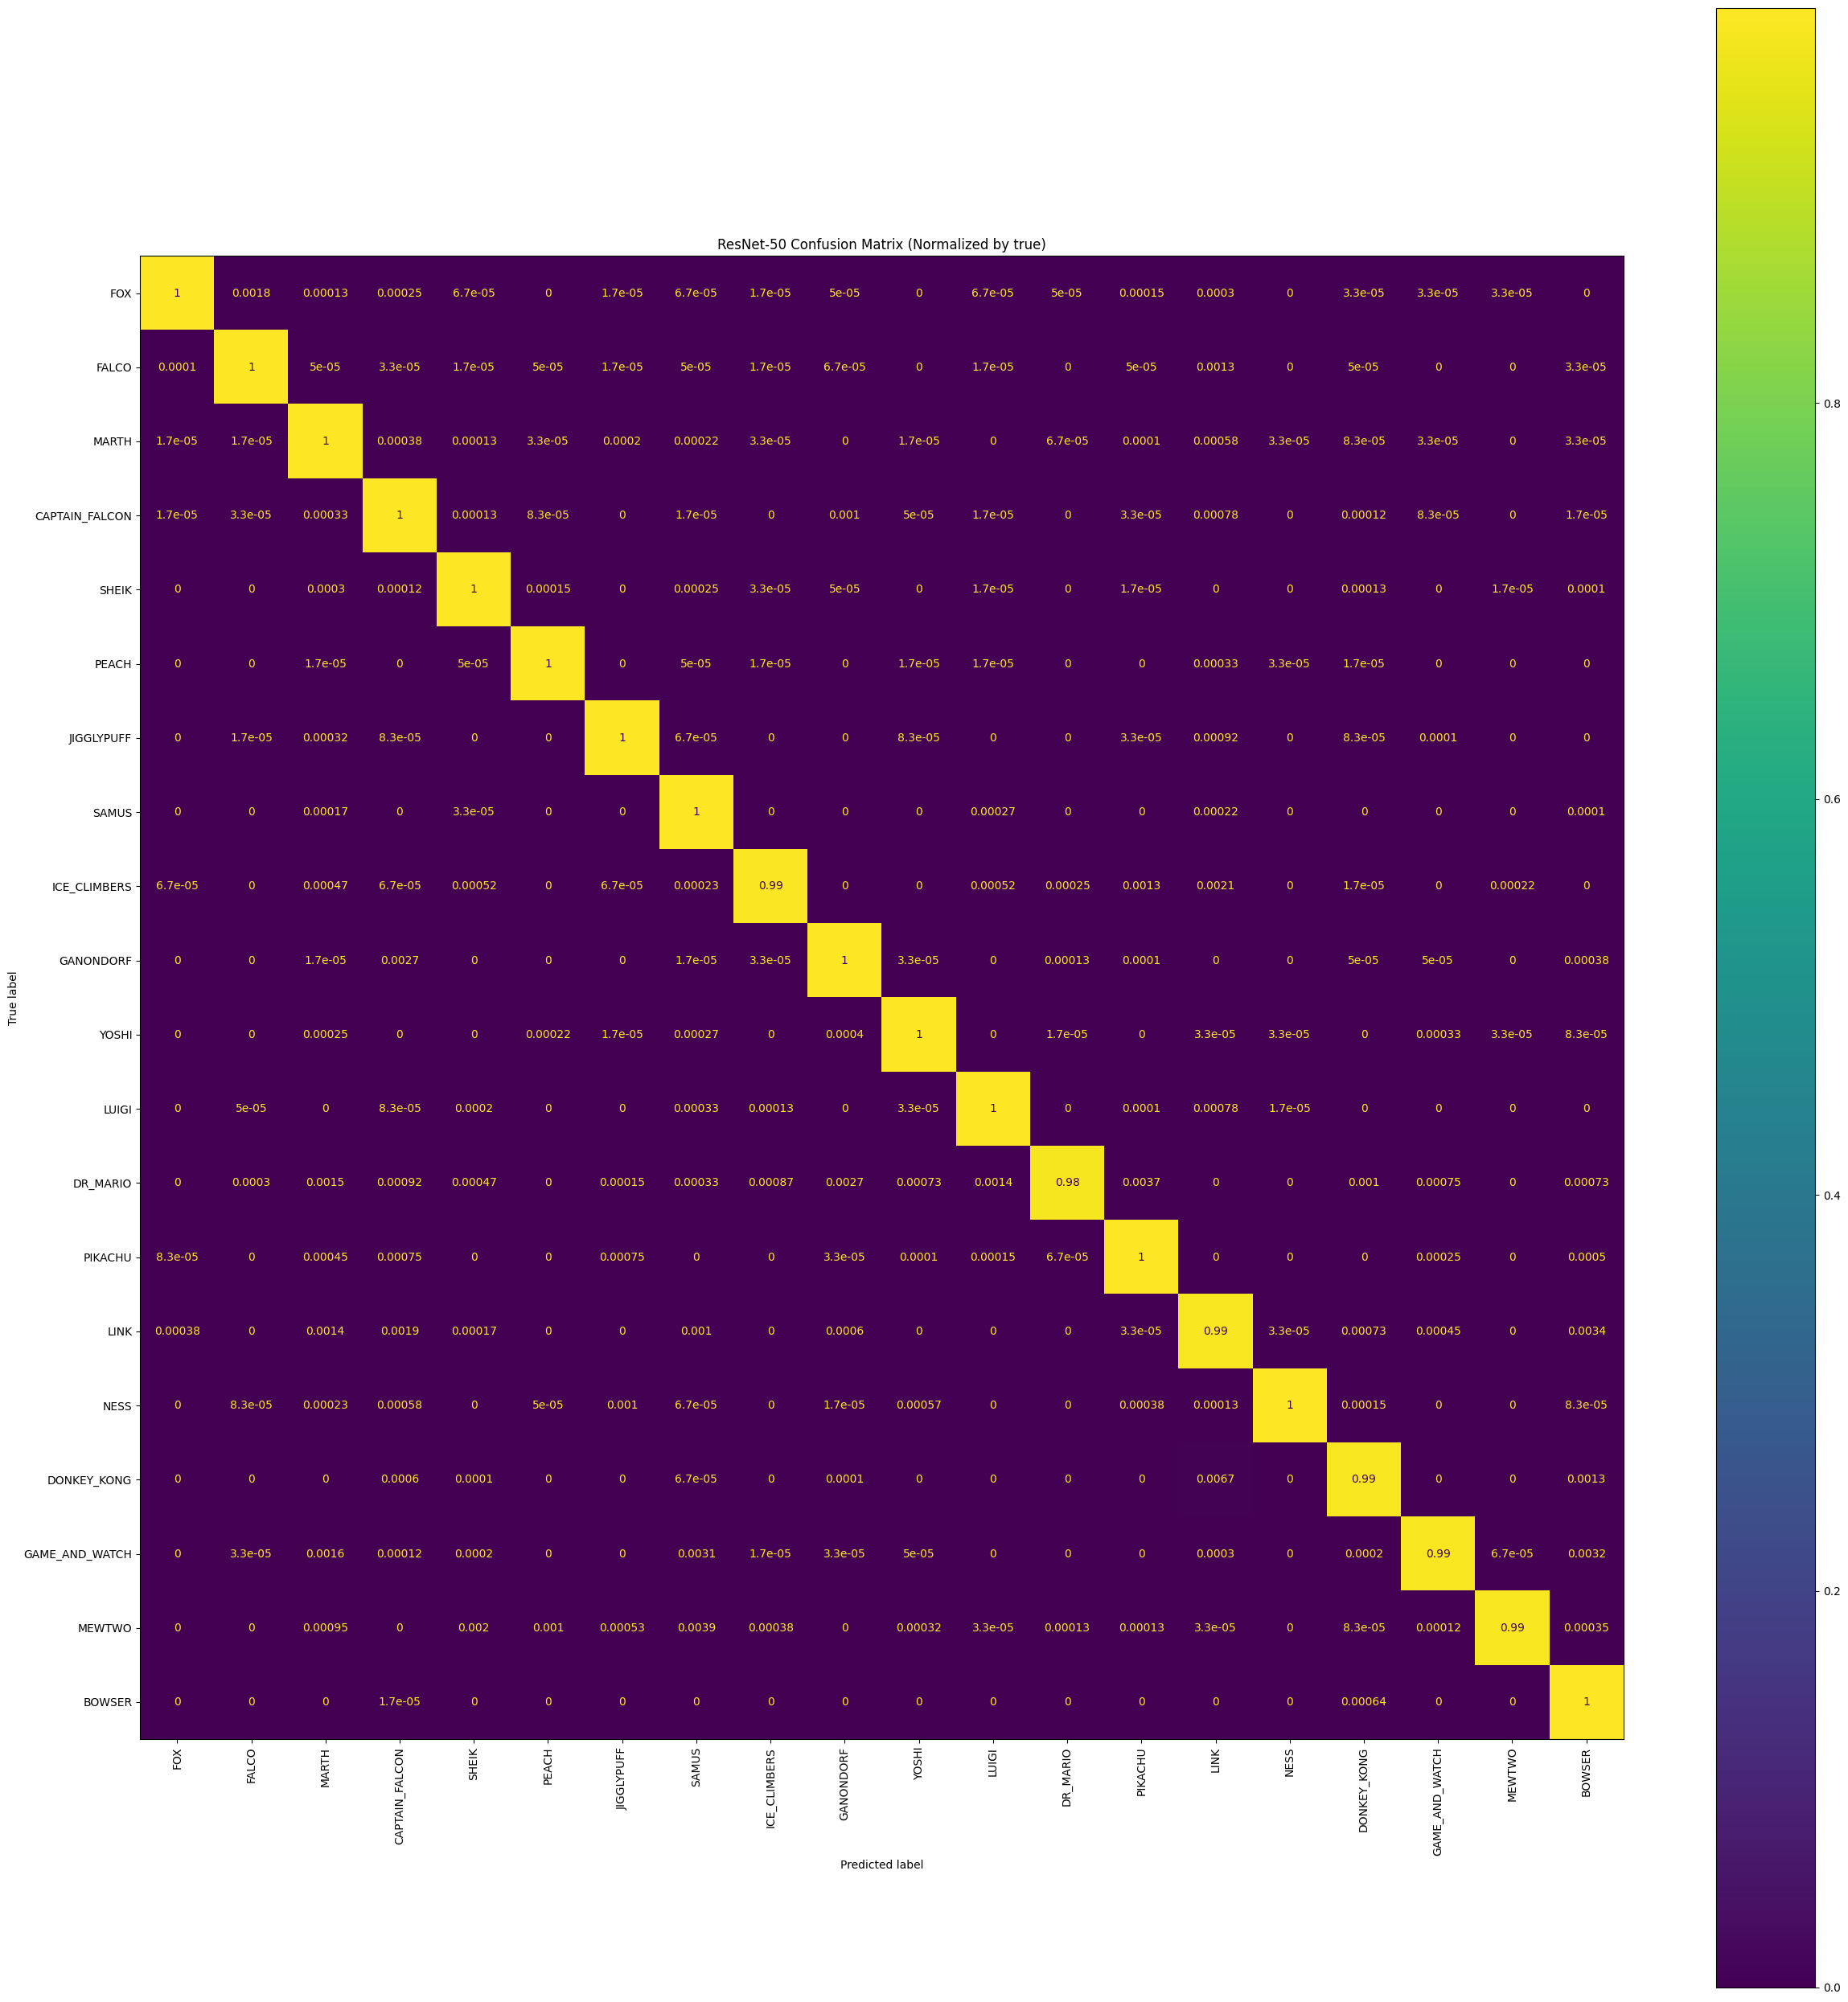

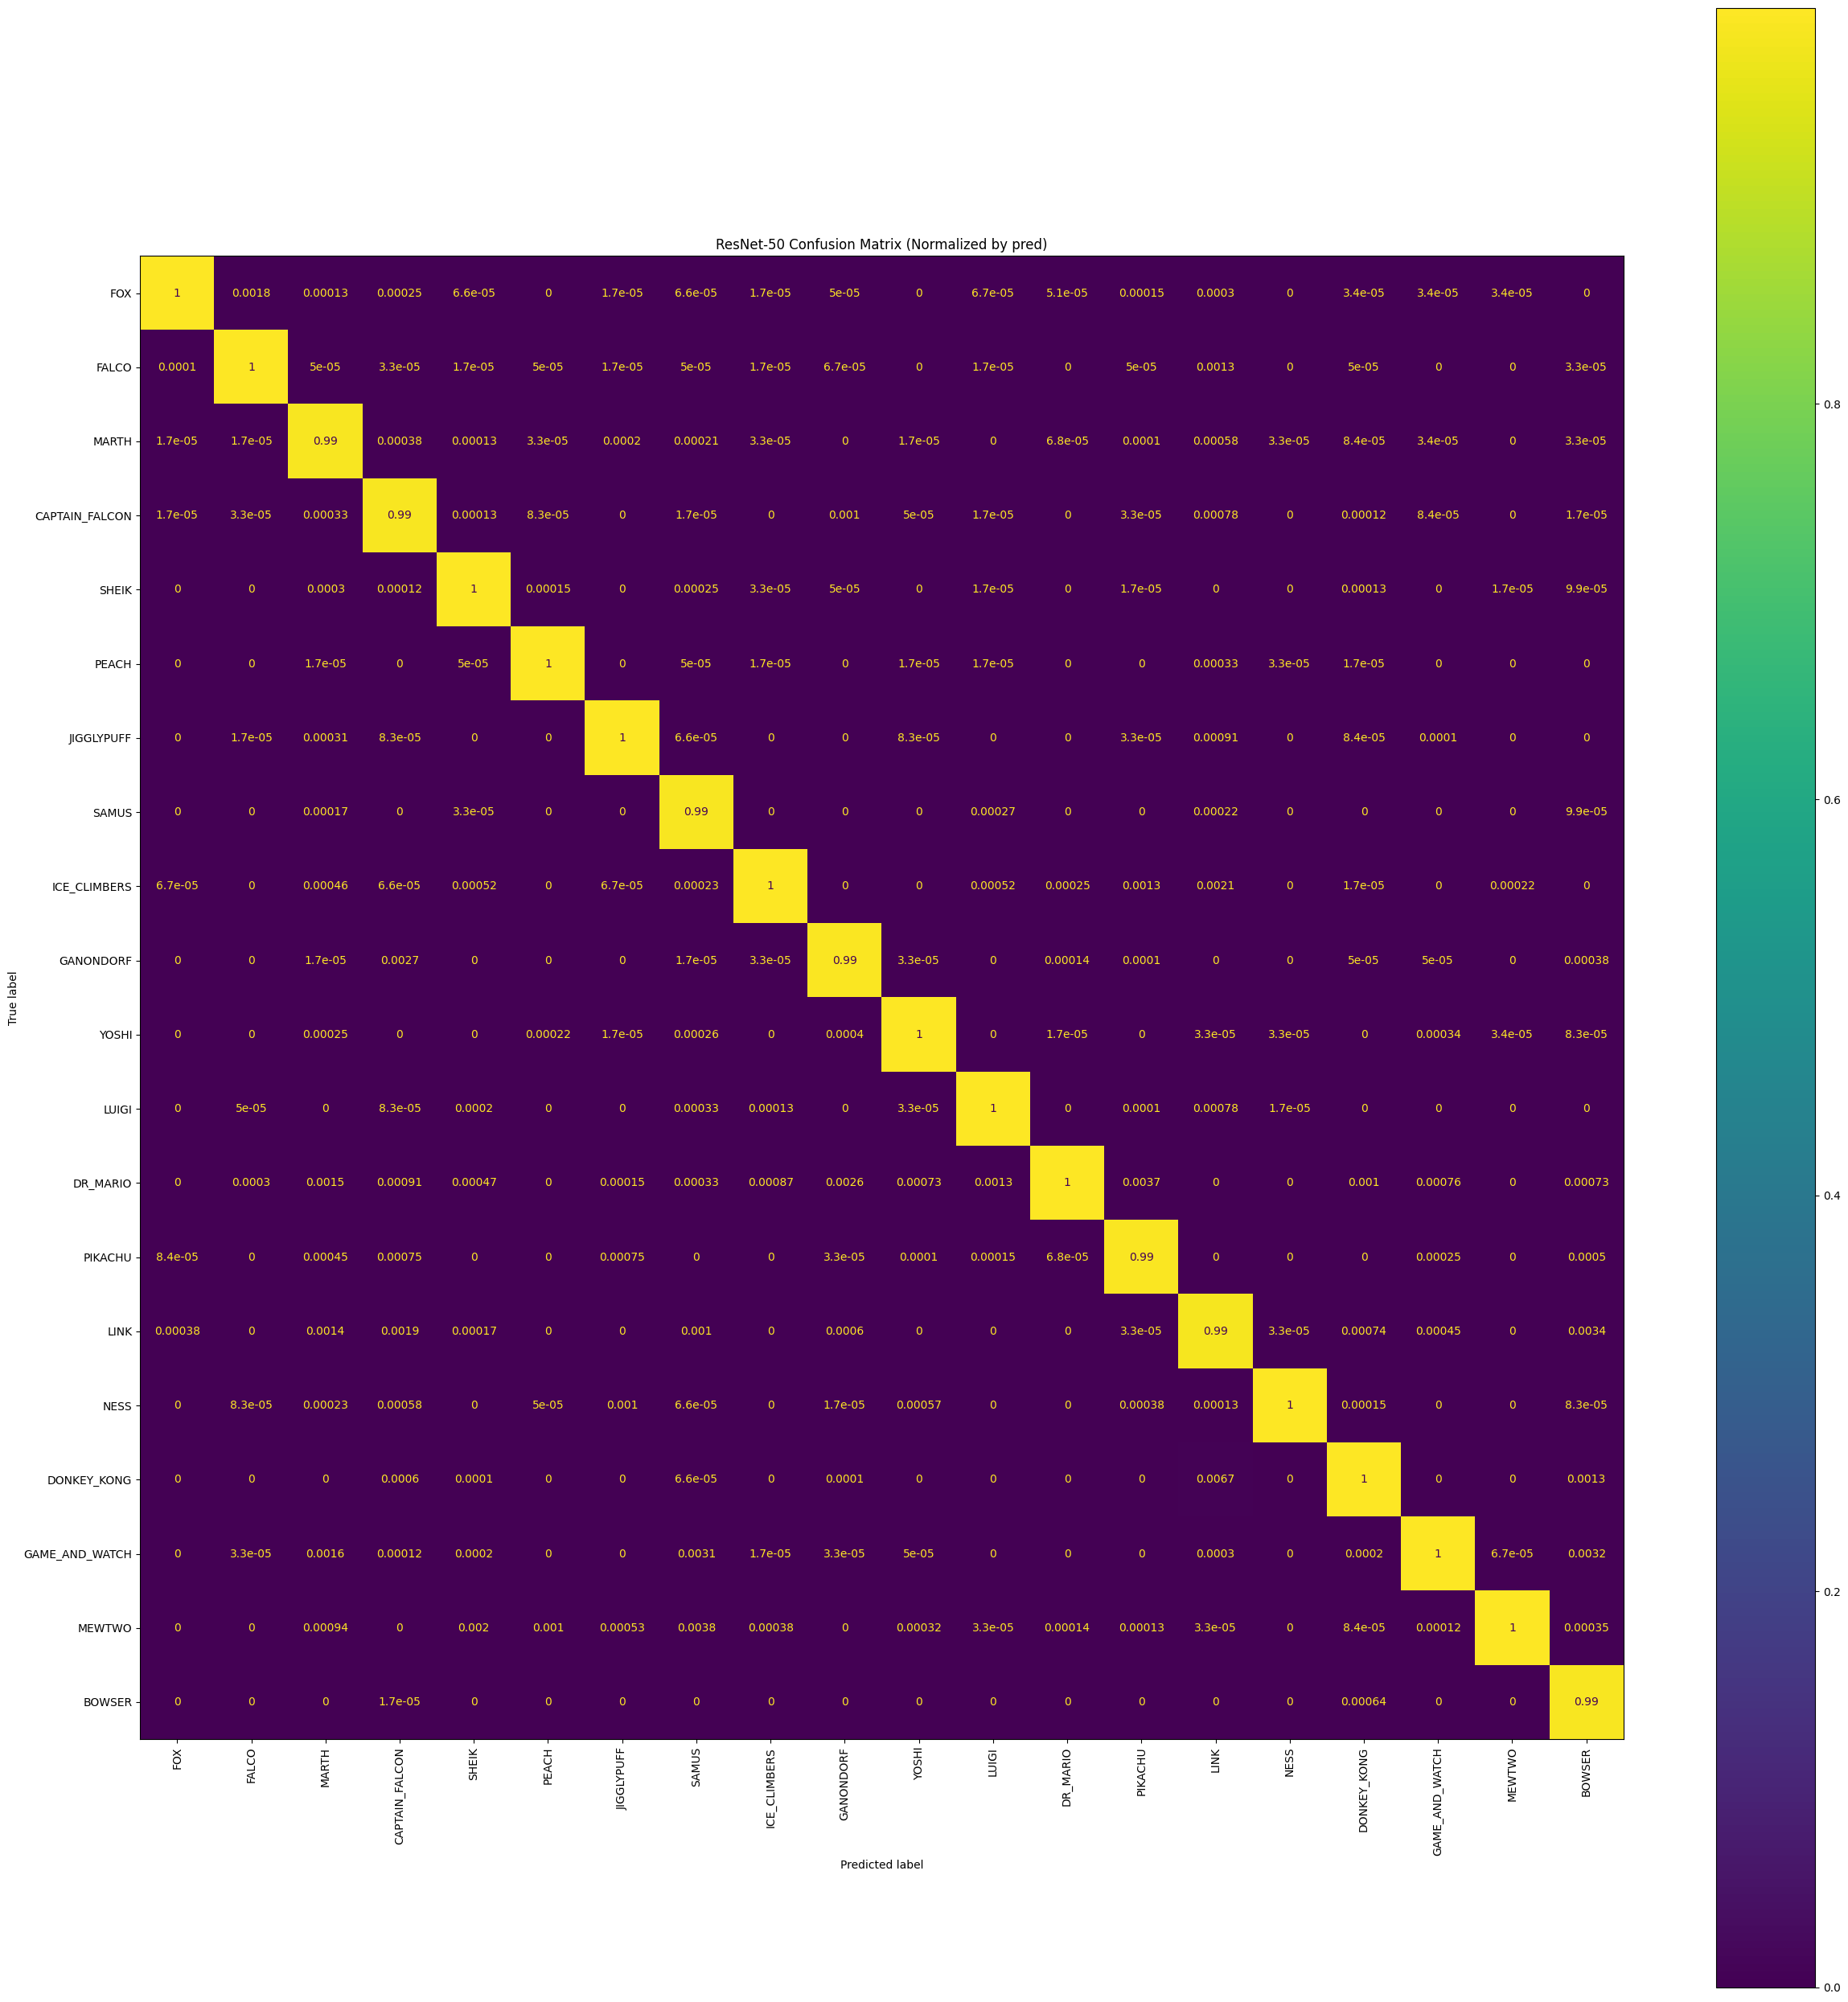

In [42]:
asses_model('ResNet-50', np.array([label_decoder.get(item, "Unknown") for item in y_pred]), np.array(test_df['labels']), labels_order)
